### Transformer

Code referenced and adopted from https://github.com/bentrevett/pytorch-seq2seq

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 11747

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [43]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TGT = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [44]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.de'), 
                                                    fields = (SRC, TGT))

In [45]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [46]:
SRC.build_vocab(train_data, min_freq = 2)
TGT.build_vocab(train_data, min_freq = 2)

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TGT.vocab)}")

Unique tokens in source (de) vocabulary: 5893
Unique tokens in target (en) vocabulary: 7855


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [11]:
class Encoder(nn.Module):
    def __init__(self, ninp, nhid, nlayers, nheads, pfdim, dropout, device, max_len=100):
        super(Encoder, self).__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(ninp, nhid)
        self.pos_embedding = nn.Embedding(max_len, nhid)
        self.layers = nn.ModuleList([EncoderLayer(nhid, nheads, pfdim, dropout, device)
                                     for _ in range(nlayers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([nhid])).to(device)
        
    def forward(self, src, src_mask):
        # src: (b, s)
        # src_mask: (b, s)
        b, s = src.shape
        pos = torch.arange(0, s).unsqueeze(0).repeat(b, 1).to(self.device)
        src = self.dropout((self.tok_embedding(src)*self.scale+self.pos_embedding(pos)))
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, nhid, nheads, pfdim, dropout, device, max_len=100):
        super(EncoderLayer, self).__init__()
        self.self_attn_layer_norm = nn.LayerNorm(nhid)
        self.ff_layer_norm = nn.LayerNorm(nhid)
        self.self_attn = MultiHeadAttentionLayer(nhid, nheads, dropout, device)
        self.positionwise_ff = PositionwiseFeedforwardLayer(nhid, pfdim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        # src: (b, s, nhid)
        # src_mask: (b, s)
        _src, _ = self.self_attn(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src+self.dropout(_src))
        # src: (b, s, nhid)
        _src = self.positionwise_ff(src)
        src = self.ff_layer_norm(src+self.dropout(_src))
        # src: (b, s, nhid)
        return src

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, nhid, nheads, dropout, device):
        super(MultiHeadAttentionLayer, self).__init__()
        assert(nhid % nheads == 0)
        
        self.nhid = nhid
        self.nheads = nheads
        self.head_dim = nhid // nheads
        
        self.fc_q = nn.Linear(nhid, nhid)
        self.fc_k = nn.Linear(nhid, nhid)
        self.fc_v = nn.Linear(nhid, nhid)
        self.fc_o = nn.Linear(nhid, nhid)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask=None):
        b = query.shape[0]
        
        # query: (b, ql, nhid), key: (b, kl, nhid), value: (b, vl, nhid)
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        Q = Q.view(b, -1, self.nheads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(b, -1, self.nheads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(b, -1, self.nheads, self.head_dim).permute(0, 2, 1, 3)
        # Q: (b, nheads, ql, head_dim)
        # K: (b, nheads, kl, head_dim)
        # V: (b, nheads, vl, head_dim)
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # energy: (b, nheads, ql, kl)
        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
        
        attn = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attn), V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(b, -1, self.nhid)
        x = self.fc_o(x)
        return x, attn

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, nhid, pfdim, dropout):
        super(PositionwiseFeedforwardLayer, self).__init__()
        self.fc_1 = nn.Linear(nhid, pfdim)
        self.fc_2 = nn.Linear(pfdim, nhid)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: (b, s, nhid)
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        return x

In [15]:
class Decoder(nn.Module):
    def __init__(self, nout, nhid, nlayers, nheads, pfdim, dropout, device, max_len=100):
        super(Decoder, self).__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(nout, nhid)
        self.pos_embedding = nn.Embedding(max_len, nhid)
        self.layers = nn.ModuleList([DecoderLayer(nhid, nheads, pfdim, dropout, device)
                                     for _ in range(nlayers)])
        self.fc_out = nn.Linear(nhid, nout)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([nhid])).to(device)
        
    def forward(self, tgt, enc_src, tgt_mask, src_mask):
        b, tgt_len = tgt.shape
        pos = torch.arange(0, tgt_len).unsqueeze(0).repeat(b, 1).to(self.device)
        tgt = self.dropout((self.tok_embedding(tgt)*self.scale)+self.pos_embedding(pos))
        for layer in self.layers:
            tgt, attn = layer(tgt, enc_src, tgt_mask, src_mask)
        out = self.fc_out(tgt)
        return out, attn
    
class DecoderLayer(nn.Module):
    def __init__(self, nhid, nheads, pfdim, dropout, device):
        super(DecoderLayer, self).__init__()
        self.self_attn_layer_norm = nn.LayerNorm(nhid)
        self.enc_attn_layer_norm = nn.LayerNorm(nhid)
        self.ff_layer_norm = nn.LayerNorm(nhid)
        self.self_attn = MultiHeadAttentionLayer(nhid, nheads, dropout, device)
        self.encoder_attn = MultiHeadAttentionLayer(nhid, nheads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(nhid, pfdim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, tgt, enc_src, tgt_mask, src_mask):
        """
        tgt: (b, tgt_len, nhid)
        enc_src: (b, sec_len, nhid)
        tgt_mask: (b, tgt_len)
        src_mask: (b, src_len)
        """
        _tgt, _ = self.self_attn(tgt, tgt, tgt, tgt_mask)
        tgt = self.self_attn_layer_norm(tgt+self.dropout(_tgt))
        
        _tgt, attn = self.encoder_attn(tgt, enc_src, enc_src, src_mask)
        tgt = self.enc_attn_layer_norm(tgt+self.dropout(_tgt))
        
        _tgt = self.positionwise_feedforward(tgt)
        tgt = self.ff_layer_norm(tgt+self.dropout(_tgt))
        return tgt, attn

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, tgt_pad_idx, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        # src: (b, s)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask: (b, 1, 1, s)
        return src_mask
    
    def make_tgt_mask(self, tgt):
        tgt_pad_mask = (tgt != self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)
        # tgt_pad_mask: (b, 1, 1, tgt len)
        tgt_len = tgt.shape[1]
        tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=self.device)).bool()
        # tgt_sub_mask: (b, tgt len)
        tgt_mask = tgt_pad_mask & tgt_sub_mask
        # tgt_mask: (b, 1, tgt len, tgt len)
        
    def forward(self, src, tgt):
        # src: (b, src len)
        # tgt: (b, tgt len)
        src_mask = self.make_src_mask(src)  # (b, 1, 1, src len)
        tgt_mask = self.make_tgt_mask(tgt)  # (b, 1, tgt len, tgt len)
        
        enc_src = self.encoder(src, src_mask)
        out, attn = self.decoder(tgt, enc_src, tgt_mask, src_mask)
        # out: (b, tgt len, nout)
        # attn: (b, nheads, tgt len, src len)
        return out, attn

In [17]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TGT.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
MAX_LEN = 150

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TGT_PAD_IDX = TGT.vocab.stoi[TGT.pad_token]

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LEN)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LEN)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TGT_PAD_IDX, device).to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,568,687 trainable parameters


In [19]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [20]:
model.apply(initialize_weights);

In [21]:
lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)

In [24]:
def train_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src.t()
        tgt = batch.trg.t()     
        optimizer.zero_grad()
        out, _ = model(src, tgt[:,:-1])  # tgt sent excluding <eos>
        nout = out.shape[-1]

        out = out.contiguous().view(-1, nout)
        tgt = tgt[:,1:].contiguous().view(-1)
        
        loss = criterion(out, tgt)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src.t()
            tgt = batch.trg.t()
            out, _ = model(src, tgt[:,:-1])
            nout = out.shape[-1]
            out = out.contiguous().view(-1, nout)
            tgt = tgt[:,1:].contiguous().view(-1)
            loss = criterion(out, tgt)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start = time.time()
    train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end = time.time()
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


In [49]:
model.load_state_dict(torch.load('tut6-model.pt', map_location=device))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.016 | Test PPL:   1.016 |


#### Inference

Template:
The steps taken are:

* tokenize the source sentence if it has not been tokenized (is a string)
* append the `<sos>` and `<eos>` tokens
* numericalize the source sentence
* convert it to a tensor and add a batch dimension
* create the source sentence mask
* feed the source sentence and mask into the encoder
* create a list to hold the output sentence, initialized with an `<sos>` token
* while we have not hit a maximum length
    * convert the current output sentence prediction into a tensor with a batch dimension
    * create a target sentence mask
    * place the current output, encoder output and both masks into the decoder
    * get next output token prediction from decoder along with attention
    * add prediction to current output sentence prediction
    * break if the prediction was an `<eos>` token
* convert the output sentence from indexes to tokens
* return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [78]:
def translate_sentence(sentence, src_field, tgt_field, model, device, max_len=50):
    model.eval()
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_idxs = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_idxs).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    tgt_idxs = [tgt_field.vocab.stoi[tgt_field.init_token]]
    
    for i in range(max_len):
        tgt_tensor = torch.LongTensor(tgt_idxs).unsqueeze(0).to(device)
        tgt_mask = model.make_tgt_mask(tgt_tensor)
        with torch.no_grad():
            out, attn = model.decoder(tgt_tensor, enc_src, tgt_mask, src_mask)
        pred_token = out.argmax(2)[:,-1].item()
        tgt_idxs.append(pred_token)
        if pred_token == tgt_field.vocab.stoi[tgt_field.eos_token]:
            break
    
    tgt_tokens = [tgt_field.vocab.itos[i] for i in tgt_idxs]
    return tgt_tokens[1:], attn

In [82]:
example_idx = 1

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']
trg = ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.']


In [83]:
translation, attn = translate_sentence(src, SRC, TGT, model, device)

In [84]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


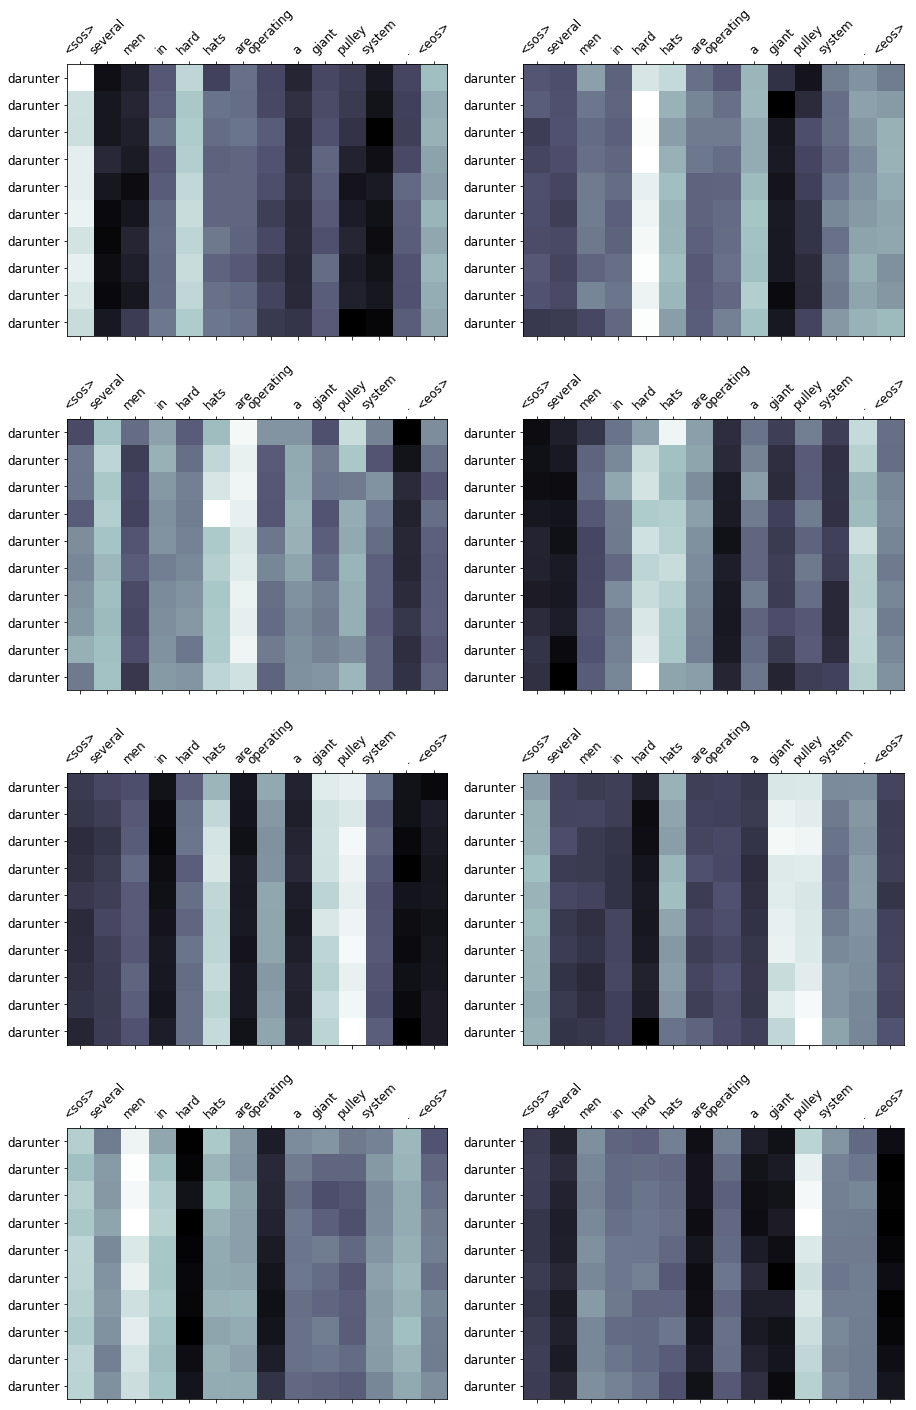

In [85]:
display_attention(src, translation, attn)
